### XGBoost

In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from processing import process_all_features_v2
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score,
                             average_precision_score, f1_score, fbeta_score, make_scorer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from typing import Tuple
import mlflow
import mlflow.sklearn

In [ ]:
# --- Configuration ---
X_PATH = "data/processed/X_train_processed.csv"
Y_PATH = "data/processed/y_train.csv"
X_VAL_PATH = "data/processed/X_val_processed.csv"
Y_VAL_PATH = "data/processed/y_val.csv"
TARGET_COLUMN = "TARGET_LABEL_BAD=1"
EXPERIMENT_NAME = "XGBoost_Preprocessed Features_Unbalanced"

# --- MLflow Autologging ---
#mlflow.set_tracking_uri("http://localhost:5000")
#mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.sklearn.autolog()

# --- Data Loading ---
def load_data(x_path, y_path, x_val_path=None, y_val_path=None):
    try:
        X = pd.read_csv(x_path)
        y = pd.read_csv(y_path)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Error loading training data: {e}. Make sure paths are correct.")

    if TARGET_COLUMN not in y.columns:
        raise ValueError(f"Missing target column: {TARGET_COLUMN}")
    print(f"Loaded X shape: {X.shape}, y shape: {y.shape}")
    print(f"Target distribution:\n{y[TARGET_COLUMN].value_counts(normalize=True)}")

    X_val, y_val = None, None
    if x_val_path and y_val_path:
        try:
            X_val = pd.read_csv(x_val_path)
            y_val = pd.read_csv(y_val_path)
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Error loading validation data: {e}. Make sure paths are correct.")
        if TARGET_COLUMN not in y_val.columns:
            raise ValueError(f"Missing target column in validation data: {TARGET_COLUMN}")
        print(f"Loaded X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
        print(f"Validation target distribution:\n{y_val[TARGET_COLUMN].value_counts(normalize=True)}")
    return X, y[TARGET_COLUMN], X_val, y_val[TARGET_COLUMN]

# --- Pipeline Building ---
def build_pipeline(smote_sampling_strategy=0.7, xgb_params=None, n_components=0.95):
    if xgb_params is None:
        xgb_params = {
            "use_label_encoder": False,
            "eval_metric": "logloss",
            "objective": "binary:logistic",
        }
    model = XGBClassifier(**xgb_params)
    pipeline = ImbPipeline(steps=[
        ("scaler", StandardScaler()),
        #("smote", SMOTE(random_state=42, sampling_strategy=smote_sampling_strategy)),
        ("smote_tomek", SMOTETomek(random_state=42)),
        ("pca", PCA(n_components=n_components)),   
        ("model", model)
    ])
    return pipeline

# --- Feature Importance Plotting ---
def plot_feature_importance(model, feature_names, output_path="reports/figures/feature_importance.png", top_n=15): # Changed default top_n to 15
    try:
        importances = model.named_steps["model"].feature_importances_
    except AttributeError:
        print("Model does not have feature_importances_ attribute.")
        return None

    indices = np.argsort(importances)[::-1]
    sorted_feature_names = np.array(feature_names)[indices]
    sorted_importances = importances[indices]

    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances (Top {})".format(top_n))
    plt.bar(range(min(top_n, len(importances))), sorted_importances[:top_n])
    plt.xticks(range(min(top_n, len(importances))), sorted_feature_names[:top_n], rotation=90)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print(f"Feature importance plot saved to {output_path}")
    return output_path

def save_model(model, output_path="models/xgb_model.pkl"):
    try:
        joblib.dump(model, output_path)
        print(f"Model saved to {output_path}")
    except Exception as e:
        print(f"Error saving model: {e}")

# --- Main Execution ---
if __name__ == "__main__":
    mlflow.set_experiment(EXPERIMENT_NAME)

    X, y, X_val, y_val = load_data(X_PATH, Y_PATH, X_VAL_PATH, Y_VAL_PATH)

    # Calculate scale_pos_weight
    neg_count = y.value_counts()[0]
    pos_count = y.value_counts()[1]
    scale_pos_weight_val = neg_count / pos_count if pos_count > 0 else 1

    # Stratified train-test split (for final evaluation)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"\nTrain set distribution:\n{y_train.value_counts(normalize=True)}")
    print(f"Test set distribution:\n{y_test.value_counts(normalize=True)}")


    # --- Hyperparameter Tuning with GridSearchCV and StratifiedKFold ---
    base_xgb_model = XGBClassifier(eval_metric="logloss",
                                   objective="binary:logistic",
                                   scale_pos_weight=scale_pos_weight_val)

    pipeline_for_tuning = ImbPipeline(steps=[
        ("scaler", StandardScaler()),
        #("smote", SMOTE(random_state=42)),
        #("smote_tomek", SMOTETomek(random_state=42)),
        ("pca", PCA()),
        ("model", base_xgb_model)
    ])

    param_grid = {
        #'smote__sampling_strategy': [0.5], #[0.5, 0.75, 1.0],
        'pca__n_components': [0.95], #[0.9, 0.95, 0.99],
        'model__n_estimators': [200], #[100, 200, 300],
        'model__learning_rate': [0.1], #[0.05, 0.1, 0.2],
        'model__max_depth': [3], #[3, 5, 7],
        'model__subsample': [1.0], #[0.7, 0.8, 1.0],
        'model__colsample_bytree': [0.7], #[0.7, 0.8, 1.0],
        'model__reg_alpha': [1], #[0, 0.1, 1],
        'model__reg_lambda': [1], #[1, 5, 10],
        'model__gamma': [0.5] #[0, 0.1, 0.5]
    }

    #scorer = make_scorer(f1_score, pos_label=1)
    scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)

    if X_val is not None and y_val is not None:
        print("\nUsing provided validation data for early stopping.")
        grid_search = GridSearchCV(
            pipeline_for_tuning,
            param_grid,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring=scorer,
            verbose=1,
            n_jobs=-1
    )
    else:
        print("\nNo validation data provided. Early stopping will not be used in GridSearchCV.")
        grid_search = GridSearchCV(
            pipeline_for_tuning,
            param_grid,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring=scorer,
            verbose=1,
            n_jobs=-1
    )

    print("\nStarting Hyperparameter Tuning...")
    with mlflow.start_run(run_name="Hyperparameter_Tuning"):
        grid_search.fit(X_train, y_train)

        best_pipeline = grid_search.best_estimator_
        print(f"\nBest parameters found: {grid_search.best_params_}")
        print(f"Best F1-score (CV): {grid_search.best_score_:.4f}")

        # Evaluate the best pipeline on the test set
        y_pred = best_pipeline.predict(X_test)
        y_prob = best_pipeline.predict_proba(X_test)[:, 1]
        y_pred_val = best_pipeline.predict(X_val)
        y_prob_val = best_pipeline.predict_proba(X_val)[:, 1]

        # Calculate and log final metrics
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        roc_auc = roc_auc_score(y_test, y_prob)
        pr_auc = average_precision_score(y_test, y_prob)

        mlflow.log_metric("test_accuracy", acc)
        mlflow.log_metric("test_roc_auc", roc_auc)
        mlflow.log_metric("test_pr_auc", pr_auc)

        # Calculate and log final metrics
        acc_val = accuracy_score(y_val, y_pred_val)
        report_val = classification_report(y_val, y_pred_val, output_dict=True)
        roc_auc_val = roc_auc_score(y_val, y_prob_val)
        pr_auc_val = average_precision_score(y_val, y_prob_val)

        mlflow.log_metric("val_accuracy", acc_val)
        mlflow.log_metric("val_roc_auc", roc_auc_val)
        mlflow.log_metric("val_pr_auc", pr_auc_val)


        for label, metrics in report.items():
            if isinstance(metrics, dict):
                for k, v in metrics.items():
                    mlflow.log_metric(f"test_{label}_{k}", v)
            else:
                mlflow.log_metric(f"test_{label}", metrics)

        for label, metrics in report_val.items():
            if isinstance(metrics, dict):
                for k, v in metrics.items():
                    mlflow.log_metric(f"val_{label}_{k}", v)
            else:
                mlflow.log_metric(f"val_{label}", metrics)

        print(f"\nTest Accuracy: {acc:.4f}")
        print(f"Test ROC AUC: {roc_auc:.4f}")
        print(f"Test PR AUC: {pr_auc:.4f}")
        print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

        print(f"\nVal Accuracy: {acc_val:.4f}")
        print(f"Val ROC AUC: {roc_auc_val:.4f}")
        print(f"Val PR AUC: {pr_auc_val:.4f}")
        print("\nVal Classification Report:\n", classification_report(y_val, y_pred_val))

        # Confusion Matrix plotting and logging
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix - Test Set")
        plt.tight_layout()
        conf_matrix_path_t = "reports/figures/confusion_matrix_xgb_test.png"
        plt.savefig(conf_matrix_path_t)
        plt.close()
        mlflow.log_artifact(conf_matrix_path_t)

        cm_val = confusion_matrix(y_val, y_pred_val)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix - Val Set")
        plt.tight_layout()
        conf_matrix_path_v = "reports/figures/confusion_matrix_xgb_val.png"
        plt.savefig(conf_matrix_path_v)
        plt.close()
        mlflow.log_artifact(conf_matrix_path_v)

        # Feature importance plot for the best model (now plots top 15 by default)
        if hasattr(best_pipeline.named_steps["model"], 'feature_importances_'):
            importance_path = plot_feature_importance(best_pipeline, X.columns, output_path="reports/figures/feature_importance_xgb.png", top_n=15)
            if importance_path:
                mlflow.log_artifact(importance_path)
        else:
            print("Feature importance cannot be plotted.")

        print(f"MLflow Run complete for {EXPERIMENT_NAME} experiment. Run ID: {mlflow.active_run().info.run_id}")

Loaded X shape: (40000, 127), y shape: (40000, 1)
Target distribution:
TARGET_LABEL_BAD=1
0    0.7381
1    0.2619
Name: proportion, dtype: float64
Loaded X_val shape: (10000, 127), y_val shape: (10000, 1)
Validation target distribution:
TARGET_LABEL_BAD=1
0    0.7435
1    0.2565
Name: proportion, dtype: float64

Train set distribution:
TARGET_LABEL_BAD=1
0    0.738094
1    0.261906
Name: proportion, dtype: float64
Test set distribution:
TARGET_LABEL_BAD=1
0    0.738125
1    0.261875
Name: proportion, dtype: float64

Using provided validation data for early stopping.

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


2025/06/26 20:51:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.



Best parameters found: {'model__colsample_bytree': 0.7, 'model__gamma': 0.5, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__subsample': 1.0, 'pca__n_components': 0.95}
Best F1-score (CV): 0.3457

Test Accuracy: 0.5906
Test ROC AUC: 0.5964
Test PR AUC: 0.3215

Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.61      0.69      5905
           1       0.33      0.53      0.40      2095

    accuracy                           0.59      8000
   macro avg       0.56      0.57      0.55      8000
weighted avg       0.66      0.59      0.61      8000


Val Accuracy: 0.5525
Val ROC AUC: 0.5737
Val PR AUC: 0.3044

Val Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.55      0.65      7435
           1       0.30      0.55      0.38      2565

    accuracy                           0.

In [3]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.78      0.55      0.65      7435
           1       0.30      0.55      0.38      2565

    accuracy                           0.55     10000
   macro avg       0.54      0.55      0.52     10000
weighted avg       0.66      0.55      0.58     10000



In [ ]:
save_model(best_pipeline, output_path="models/xgb_model_best.pkl")

### Stacking Classifier

In [75]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier


In [115]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

In [94]:
xgb = XGBClassifier(
    eval_metric="logloss",
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight_val,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=0.7,
    reg_alpha=1,
    reg_lambda=1,
    gamma=0.5,
    use_label_encoder=False,
    random_state=42
)

rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)

# Optional: SVM or Naive Bayes if you want to expand
svc = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale')
nb = GaussianNB()

meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')

In [116]:
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('knn', knn),
        ('svc', svc),     # Optional
        ('nb', nb)        # Optional
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

stacking_pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(k=20)),
    #('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
    ("pca", PCA(n_components=0.95)),
    ('stacking', stacking_model)
])


print("\nTraining Stacked Model with Diverse Base Learners...")
stacking_pipeline.fit(X_train, y_train)

y_pred = stacking_pipeline.predict(X_test)
y_prob = stacking_pipeline.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

print("\nStacked Model - Classification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(f"PR AUC: {average_precision_score(y_test, y_prob):.4f}")



Training Stacked Model with Diverse Base Learners...


2025/06/25 19:45:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cdff786b714d4d18b8891f1db47a8fb4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/06/25 19:45:43 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/06/25 19:45:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/06/25 19:45:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '92a51a4d975a47ada34054a20a40b972', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/06/25 19:45:49 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



Stacked Model - Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.55      0.65      5905
           1       0.33      0.62      0.43      2095

    accuracy                           0.57      8000
   macro avg       0.57      0.59      0.54      8000
weighted avg       0.68      0.57      0.59      8000

ROC AUC: 0.6170
PR AUC: 0.3426


In [117]:
y_pred_v = stacking_pipeline.predict(X_val)
y_prob_v = stacking_pipeline.predict_proba(X_val)[:, 1]

print("\nStacked Model - Classification Report:")
print(classification_report(y_val, y_pred_v))

print(f"ROC AUC: {roc_auc_score(y_val, y_prob_v):.4f}")
print(f"PR AUC: {average_precision_score(y_val, y_prob_v):.4f}")


Stacked Model - Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.44      0.58      7435
           1       0.31      0.71      0.43      2565

    accuracy                           0.51     10000
   macro avg       0.56      0.58      0.50     10000
weighted avg       0.69      0.51      0.54     10000

ROC AUC: 0.6050
PR AUC: 0.3251


#### Get selected features

In [118]:
mask = stacking_pipeline.named_steps["feature_selection"].get_support()

# Step 2: Apply mask to original feature names
selected_feature_names = X_train.columns[mask]

# Optional: print or use them
print("Features selected before PCA:")
print(selected_feature_names.tolist())

Features selected before PCA:
['MARITAL_STATUS', 'MONTHS_IN_RESIDENCE', 'AGE', 'OCCUPATION_TYPE', 'SEX_F', 'SEX_M', 'FLAG_RESIDENCIAL_PHONE_Y', 'STATE_OF_BIRTH_RS', 'STATE_OF_BIRTH_SC', 'RESIDENCIAL_STATE_RS', 'RESIDENCIAL_STATE_SC', 'RESIDENCE_TYPE_1.0', 'RESIDENCE_TYPE_2.0', 'PROFESSIONAL_STATE_ ', 'PRODUCT_7', 'RESIDENCIAL_CITY', 'RESIDENCIAL_BOROUGH', 'RESIDENCIAL_PHONE_AREA_CODE', 'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3']


In [ ]:
feat_select = ['MARITAL_STATUS', 'MONTHS_IN_RESIDENCE', 'AGE', 'OCCUPATION_TYPE',
               'SEX', 'FLAG_RESIDENCIAL_PHONE', 'STATE_OF_BIRTH',
               'RESIDENCIAL_STATE', 'RESIDENCE_TYPE', 'PROFESSIONAL_STATE', 'PRODUCT',
               'RESIDENCIAL_CITY', 'RESIDENCIAL_BOROUGH', 'RESIDENCIAL_PHONE_AREA_CODE',
               'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3']

#### Save model

In [ ]:
save_model(stacking_pipeline, output_path="models/stacking_model.pkl")

Stacking model saved to models/stacking_model.pkl


#### Plot Precision Recall Curve

In [86]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresholds = precision_recall_curve(y_val, y_prob_v)

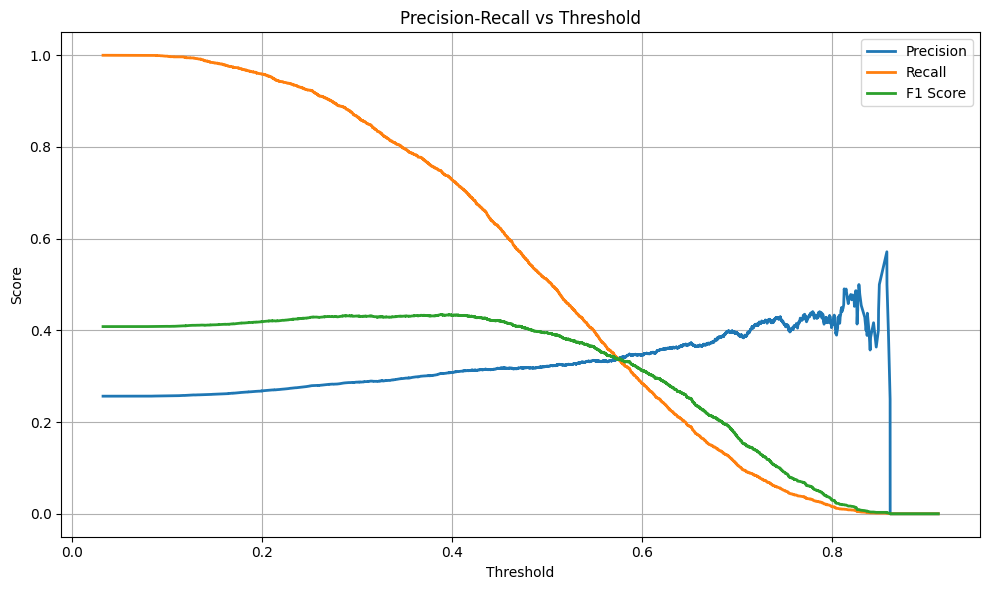

In [87]:
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, prec[:-1], label='Precision', linewidth=2)
plt.plot(thresholds, rec[:-1], label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', linewidth=2)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Optimal threshold test

In [88]:
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (F1-max): {optimal_threshold:.4f}")

Optimal Threshold (F1-max): 0.3887


In [89]:
y_pred_optimal = (y_prob_v >= optimal_threshold).astype(int)

# Evaluate performance
#from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_val, y_pred_optimal))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_optimal))


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.83      0.42      0.55      7435
           1       0.31      0.75      0.43      2565

    accuracy                           0.50     10000
   macro avg       0.57      0.58      0.49     10000
weighted avg       0.69      0.50      0.52     10000


Confusion Matrix:
[[3091 4344]
 [ 646 1919]]


### MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

# --- MLP com early stopping ---
base_mlp_model = MLPClassifier(
    random_state=42,
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)

pipeline_for_tuning = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    #("smote_tomek", SMOTETomek(random_state=42)),
    ("pca", PCA()),
    ("model", base_mlp_model)
])

# --- Hiperparâmetros para MLP ---
param_grid = {
    'pca__n_components': [0.95],
    'model__hidden_layer_sizes': [(100,), (64, 32), (128, 64)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001],
    'model__learning_rate_init': [0.001, 0.01]
}

scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)

grid_search = GridSearchCV(
    pipeline_for_tuning,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# --- Execução do GridSearch + avaliação ---
print("\nIniciando busca por hiperparâmetros (MLP)...")
with mlflow.start_run(run_name="MLP_Hyperparameter_Tuning"):
    grid_search.fit(X_train, y_train)

    best_pipeline = grid_search.best_estimator_
    print(f"\nMelhores parâmetros encontrados: {grid_search.best_params_}")
    print(f"Melhor F0.5-score (CV): {grid_search.best_score_:.4f}")

    # Previsões
    y_pred = best_pipeline.predict(X_test)
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    y_pred_val = best_pipeline.predict(X_val)
    y_prob_val = best_pipeline.predict_proba(X_val)[:, 1]

    # Métricas - Teste
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)

    mlflow.log_metric("test_accuracy", acc)
    mlflow.log_metric("test_roc_auc", roc_auc)
    mlflow.log_metric("test_pr_auc", pr_auc)

    # Métricas - Validação
    acc_val = accuracy_score(y_val, y_pred_val)
    report_val = classification_report(y_val, y_pred_val, output_dict=True)
    roc_auc_val = roc_auc_score(y_val, y_prob_val)
    pr_auc_val = average_precision_score(y_val, y_prob_val)

    mlflow.log_metric("val_accuracy", acc_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_pr_auc", pr_auc_val)

    # Logging detalhado de métricas
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            for k, v in metrics.items():
                mlflow.log_metric(f"test_{label}_{k}", v)
        else:
            mlflow.log_metric(f"test_{label}", metrics)

    for label, metrics in report_val.items():
        if isinstance(metrics, dict):
            for k, v in metrics.items():
                mlflow.log_metric(f"val_{label}_{k}", v)
        else:
            mlflow.log_metric(f"val_{label}", metrics)

    print(f"\nTest Accuracy: {acc:.4f}")
    print(f"Test ROC AUC: {roc_auc:.4f}")
    print(f"Test PR AUC: {pr_auc:.4f}")
    print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

    print(f"\nVal Accuracy: {acc_val:.4f}")
    print(f"Val ROC AUC: {roc_auc_val:.4f}")
    print(f"Val PR AUC: {pr_auc_val:.4f}")
    print("\nVal Classification Report:\n", classification_report(y_val, y_pred_val))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Test Set")
    conf_matrix_path_t = "reports/figures/confusion_matrix_mlp_test.png"
    plt.tight_layout()
    plt.savefig(conf_matrix_path_t)
    plt.close()
    mlflow.log_artifact(conf_matrix_path_t)

    cm_val = confusion_matrix(y_val, y_pred_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Val Set")
    conf_matrix_path_v = "reports/figures/confusion_matrix_mlp_val.png"
    plt.tight_layout()
    plt.savefig(conf_matrix_path_v)
    plt.close()
    mlflow.log_artifact(conf_matrix_path_v)

    # --- Curva de perda do MLP ---
    best_model = best_pipeline.named_steps["model"]
    if hasattr(best_model, "loss_curve_"):
        plt.plot(best_model.loss_curve_)
        plt.title("MLP Loss Curve")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        loss_path = "reports/figures/mlp_loss_curve.png"
        plt.tight_layout()
        plt.savefig(loss_path)
        plt.close()
        mlflow.log_artifact(loss_path)

    print(f"\nMLflow Run successfuly finished: {mlflow.active_run().info.run_id}")




Iniciando busca por hiperparâmetros (MLP)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/06/25 15:10:43 INFO mlflow.sklearn.utils: Logging the 5 best runs, 19 runs will be omitted.



Melhores parâmetros encontrados: {'model__activation': 'tanh', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (128, 64), 'model__learning_rate_init': 0.001, 'pca__n_components': 0.95}
Melhor F0.5-score (CV): 0.0866

Test Accuracy: 0.7352
Test ROC AUC: 0.6093
Test PR AUC: 0.3296

Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.99      0.85      5905
           1       0.36      0.01      0.03      2095

    accuracy                           0.74      8000
   macro avg       0.55      0.50      0.44      8000
weighted avg       0.64      0.74      0.63      8000


Val Accuracy: 0.7358
Val ROC AUC: 0.5981
Val PR AUC: 0.3191

Val Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.98      0.85      7435
           1       0.28      0.02      0.04      2565

    accuracy                           0.74     10000
   macro avg       0.51      0.50      0.44     1

In [101]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.74      0.98      0.85      7435
           1       0.28      0.02      0.04      2565

    accuracy                           0.74     10000
   macro avg       0.51      0.50      0.44     10000
weighted avg       0.63      0.74      0.64     10000



In [ ]:
save_model(best_pipeline, output_path="models/mlp_model_best.pkl")

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score,
    average_precision_score, confusion_matrix, ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import mlflow
import mlflow.sklearn
from packaging import version

# --- Configuration ---
X_PATH = "data/processed/X_train_p.csv"
Y_PATH = "data/processed/y_train.csv"
X_VAL_PATH = "data/processed/X_val_p.csv"
Y_VAL_PATH = "data/processed/y_val.csv"
TARGET_COLUMN = "TARGET_LABEL_BAD=1"
EXPERIMENT_NAME = "XGBoost_Clustering_Strategy"

# --- Logging Setup ---
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

mlflow.sklearn.autolog()

XGB_BASE_PARAMS = {
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "objective": "binary:logistic"
}

# Version check
XGB_SUPPORTS_EARLY_STOPPING = version.parse(xgboost.__version__) >= version.parse("1.3.0")

def load_data(x_path, y_path, x_val_path=None, y_val_path=None):
    X = pd.read_csv(x_path)
    y = pd.read_csv(y_path)
    if TARGET_COLUMN not in y.columns:
        raise ValueError(f"Missing target column: {TARGET_COLUMN}")
    X_val, y_val = None, None
    if x_val_path and y_val_path:
        X_val = pd.read_csv(x_val_path)
        y_val = pd.read_csv(y_val_path)
        if TARGET_COLUMN not in y_val.columns:
            raise ValueError(f"Missing target column in validation data: {TARGET_COLUMN}")
    return X, y[TARGET_COLUMN], X_val, y_val[TARGET_COLUMN] if y_val is not None else None

def resample_data(X, y, strategy=0.75):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    smote = SMOTE(random_state=42, sampling_strategy=strategy)
    X_res, y_res = smote.fit_resample(X_scaled, y)
    return X_res, y_res, scaler

def train_xgb_model(X_train, y_train, X_val=None, y_val=None, params=None):
    model = XGBClassifier(**params)
    if X_val is not None and y_val is not None and XGB_SUPPORTS_EARLY_STOPPING:
        model = XGBClassifier(**params, callbacks=[EarlyStopping(
            rounds=10,
            maximize=False,
            save_best=True
        )])
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
    else:
        if not XGB_SUPPORTS_EARLY_STOPPING:
            logger.warning("Early stopping is not supported in this version of XGBoost.")
        model.fit(X_train, y_train)
    return model

def evaluate_model(y_true, y_pred, y_prob, run_name="Evaluation"):
    acc = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    with mlflow.start_run(run_name=run_name):
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("pr_auc", pr_auc)
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                for k, v in metrics.items():
                    mlflow.log_metric(f"{label}_{k}", v)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.savefig("confusion_matrix.png")
        plt.close()
        mlflow.log_artifact("confusion_matrix.png")
    logger.info(f"Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")

# --- Main Execution ---
if __name__ == "__main__":
    mlflow.set_experiment(EXPERIMENT_NAME)
    X, y, X_val, y_val = load_data(X_PATH, Y_PATH, X_VAL_PATH, Y_VAL_PATH)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Clustering
    scaler_for_cluster = StandardScaler()
    X_train_scaled_for_cluster = scaler_for_cluster.fit_transform(X_train)
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    train_clusters = kmeans.fit_predict(X_train_scaled_for_cluster)
    test_clusters = kmeans.predict(scaler_for_cluster.transform(X_test))
    val_clusters = kmeans.predict(scaler_for_cluster.transform(X_val)) if X_val is not None else None

    # Fallback model
    X_res, y_res, fallback_scaler = resample_data(X_train, y_train)
    fallback_params = XGB_BASE_PARAMS.copy()
    fallback_params["scale_pos_weight"] = y_train.value_counts()[0] / y_train.value_counts()[1]
    X_val_scaled = fallback_scaler.transform(X_val) if X_val is not None else None
    fallback_model = train_xgb_model(X_res, y_res, X_val_scaled, y_val, fallback_params)
    mlflow.sklearn.log_model(fallback_model, artifact_path="fallback_model")

    cluster_models = {}
    with mlflow.start_run(run_name="Train_Cluster_Models"):
        for cid in np.unique(train_clusters):
            idx = train_clusters == cid
            X_c, y_c = X_train[idx], y_train[idx]
            if len(X_c) < 100 or y_c.sum() < 10:
                cluster_models[cid] = ("fallback", fallback_scaler)
                continue
            X_res_c, y_res_c, scaler_c = resample_data(X_c, y_c, strategy=0.5)
            if X_val is not None and val_clusters is not None:
                val_idx = val_clusters == cid
                X_val_c = X_val[val_idx]
                y_val_c = y_val[val_idx]
                X_val_c_scaled = scaler_c.transform(X_val_c) if len(X_val_c) > 0 else None
            else:
                X_val_c_scaled, y_val_c = None, None
            params_c = XGB_BASE_PARAMS.copy()
            params_c["scale_pos_weight"] = (len(y_c) - y_c.sum()) / y_c.sum()
            model_c = train_xgb_model(X_res_c, y_res_c, X_val_c_scaled, y_val_c, params_c)
            cluster_models[cid] = (model_c, scaler_c)
            mlflow.sklearn.log_model(model_c, artifact_path=f"cluster_{cid}_model")

    # Prediction
    y_pred, y_prob = np.zeros(len(X_test), dtype=int), np.zeros(len(X_test))
    for cid in np.unique(test_clusters):
        idx = test_clusters == cid
        model, scaler = cluster_models.get(cid, (fallback_model, fallback_scaler))
        if model == "fallback":
            model = fallback_model
            scaler = fallback_scaler
        X_test_scaled = scaler.transform(X_test[idx])
        y_pred[idx] = model.predict(X_test_scaled)
        y_prob[idx] = model.predict_proba(X_test_scaled)[:, 1]

    evaluate_model(y_test, y_pred, y_prob, run_name="Test_Evaluation")

2025/06/18 21:12:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '706914c8b6a446698586916f7eb85593', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/06/18 21:13:07 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/06/18 21:13:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '39a88542a827494ba139fba494da4ce0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/06/18 21:13:07 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/06/18 21:13:07 WARNING mlflow.sklearn: Mode